In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Assignment 3 – Practical Deep Learning Workshop

In [ ]:
%matplotlib inline
import pandas as pd
pd.set_option('display.max_colwidth', 200)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Embedding, Subtract, Lambda, Masking, Conv1D, GlobalMaxPooling1D ,Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import backend as K
from xgboost import XGBRegressor
from math import sqrt


# a.	Preprocess the training and testing data to contain sequences of single characters. Note that you should do the above for both the search phrase and the item description.

In [ ]:
# loading data
# folder_data_path = r'drive/My Drive/DeepLearnCourse/ass3/'
folder_data_path = r'drive/My Drive/Ass3_files/'
product_descriptions = pd.read_csv(folder_data_path + 'product_descriptions.csv')
solution = pd.read_csv(folder_data_path + 'solution.csv')
solution = solution[solution['Usage']!='Ignored'] # some rows are -1 and we got relevance btw 1-3
train = pd.read_csv(folder_data_path + 'train.csv',encoding = "ISO-8859-1")
test = pd.read_csv(folder_data_path + 'test.csv',encoding = "ISO-8859-1")

# join tables
train_df = train.merge(product_descriptions, how='inner', on='product_uid')
solution = solution.drop(columns=['Usage'], axis=1)
test_df = test.merge(solution, how='inner', on='id')
test_df = test_df.merge(product_descriptions, how='inner', on='product_uid')

In [ ]:
train_df

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-du..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-du..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating,deck over,3.00,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, weathered wood or concrete back to life. The advanced 100% acrylic resin formula creates a durable coat..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),rain shower head,2.33,"Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has a sleek, modern and minimalistic aesthetic. The MultiChoice universal valve keeps the water temperat..."
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),shower only faucet,2.67,"Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has a sleek, modern and minimalistic aesthetic. The MultiChoice universal valve keeps the water temperat..."
...,...,...,...,...,...,...
74062,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray or Games Maple Sliding Glass Door Media Cabinet,tv riser glass,1.00,"Atlantic, Inc. 94835722 Uniquely designed for maximum media storage, this sophisticated cabinet fits traditional living rooms and upscale decor. Formal, elegant and functional two-way sliding glas..."
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (12-Pack),r20 halogen light,3.00,"Philips Energy Advantage lamps use less energy while maintaining bright, crisp, white halogen light. Available in traditional lamp shapes to fit most incandescent fixtures. Halogen energy savers w..."
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handleset with Left-Hand Accent Lever,schlage lock siena half dummy knob with,2.33,The Schlage Camelot In-Active Aged Bronze Handleset with Left-Hand Accent Lever is perfect for use as a decorative door pull on a pair of non-latching doors. The interior Accent lever is widely po...
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor Steel,zen garden decor,3.00,The Rose Garden is inspired by the popular early 20th century Scottish design motif. Dark Bronze powder coated finish on steel makes it suitable for indoor or outdoor use.Indoor and outdoor useFin...


In [ ]:
del train, test, product_descriptions, solution

In [ ]:
results = pd.DataFrame({'Model': [], 'Runtime':[], 'Train_RMSE': [],
                       'Val_RMSE': [], 'Test_RMSE':[], 'Train_MAE': [],
                       'Val_MAE': [], 'Test_MAE': []})

In [ ]:
def append_results(model, end, train_rmse, val_rmse, test_rmse, train_mae, val_mae, test_mae):
    global results
    res = pd.Series({'Model': model, 
                     'Runtime': end,
                     'Train_RMSE': train_rmse,
                     'Val_RMSE': val_rmse,
                     'Test_RMSE': test_rmse,
                     'Train_MAE': train_mae,
                     'Val_MAE': val_mae,
                     'Test_MAE': test_mae})
    results = results.append(res, ignore_index=True)

In [ ]:
def plot_metrics_results(model_name,metric_name,score_1,score_2,score_3):
    metrics_names = (metric_name +' train',metric_name +' val',metric_name +' test')
    y_pos = np.arange(len(metrics_names))
    performance = [score_1,score_2, score_3]
    plt.bar(y_pos, performance, align='center', alpha=0.2)
    plt.xticks(y_pos, metrics_names)
    plt.ylabel(metric_name)
    plt.title(model_name +' '+metric_name +' metric results:')
    plt.show()

In [ ]:
# turn all data to lower case to get smaller dictionaries
train_df['search_term'] = train_df['search_term'].str.lower()
train_df['product_description'] = train_df['product_description'].str.lower()

test_df['search_term'] = test_df['search_term'].str.lower()
test_df['product_description'] = test_df['product_description'].str.lower()

In [ ]:
# get all tokens in data to create a char2index and index2char dictionaries
tokens = set(' '.join(train_df.search_term.tolist()) +\
             ' '.join(train_df.product_description.tolist())+\
             ' '.join(test_df.search_term.tolist()) +\
             ' '.join(test_df.product_description.tolist())) 

char2index = {c: i+1 for i, c in enumerate(tokens)}
index2char = {i: c for c, i in char2index.items()}

In [ ]:
len(char2index)

68

In [ ]:
# turn train_df words to chars
train_df_char = pd.DataFrame({'search_term': [], 'product_description': [], 'relevance':[]})
train_df_char['search_term'] = train_df['search_term'].apply(lambda term: np.array([char2index[char] for char in term]))
train_df_char['product_description'] = train_df['product_description'].apply(lambda term: [char2index[char] for char in term])
train_df_char['relevance'] = train_df['relevance']

# turn test_df description to chars
test_df_char = pd.DataFrame({'search_term': [], 'product_description': [], 'relevance':[]})
test_df_char['search_term'] = test_df['search_term'].apply(lambda term: np.array([char2index[char] for char in term]))
test_df_char['product_description'] = test_df['product_description'].apply(lambda term: [char2index[char] for char in term])
test_df_char['relevance'] = test_df['relevance']



In [ ]:
# longest search term
train_df_char.search_term.apply(len).max()

60

In [ ]:
# longest product_description
train_df_char.product_description.apply(len).max()
# we get a very long description and therefore we would not want the proccess to take long so we will be focusing on 1000 first chars
# assumption - most of relevant info would be at the begining of the description

5516

In [ ]:
# turn train_df and test_df description to first 1000 chars
train_df_char = pd.DataFrame({'search_term': [], 'product_description': [], 'relevance':[]})
train_df_char['search_term'] = train_df['search_term'].apply(lambda term: np.array([char2index[char] for char in term[:1000]]))
train_df_char['product_description'] = train_df['product_description'].apply(lambda term: [char2index[char] for char in term[:1000]])
train_df_char['relevance'] = train_df['relevance']

test_df_char = pd.DataFrame({'search_term': [], 'product_description': [], 'relevance':[]})
test_df_char['search_term'] = test_df['search_term'].apply(lambda term: np.array([char2index[char] for char in term[:1000]]))
test_df_char['product_description'] = test_df['product_description'].apply(lambda term: [char2index[char] for char in term[:1000]])
test_df_char['relevance'] = test_df['relevance']

# b.	Construct and train a Siamese network as described in the above liked paper.  The input to the network should be the character sequences constructing the search phrase and the item description, and the output should be the predicted search relevance score

In [ ]:
# siamese model

def build_siamese_model(seq_length, vocab_size, embedding_size=64):

    # Search
    search_input = Input((seq_length,),name="Search_Input")

    embedding = Embedding(input_dim=vocab_size+1, output_dim=embedding_size, input_length=seq_length,name='Search_Embedding')(search_input)
    lstm = LSTM(128, return_sequences=False, activation='tanh',name='Search_lstm')(embedding)
    search_output = Dense(64, activation='relu',name='Search_Output')(lstm)

    # Description
    description_input = Input((seq_length,),name="Description_Input")

    embedding = Embedding(input_dim=vocab_size+1, output_dim=embedding_size, input_length=seq_length,name='Description_Embedding')(description_input)
    lstm = LSTM(128, return_sequences=False, activation='tanh',name='Description_lstm')(embedding)
    description_output = Dense(64, activation='relu',name='Description_Output')(lstm)


    similarity = Subtract(name='subtract')([search_output, description_output])
    similarity = Lambda(lambda x: tf.math.abs(x))(similarity)
    relevance = Dense(1, activation='relu',name='Model_Output')(similarity)
    siamese_net = Model(inputs=[search_input, description_input], outputs=relevance)

    return siamese_net

In [ ]:
max_seq_length = 1000
siamese_net_char = build_siamese_model(max_seq_length, vocab_size=len(char2index))
siamese_net_char.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
siamese_net_char.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Search_Input (InputLayer)       [(None, 1000)]       0                                            
__________________________________________________________________________________________________
Description_Input (InputLayer)  [(None, 1000)]       0                                            
__________________________________________________________________________________________________
Search_Embedding (Embedding)    (None, 1000, 64)     4416        Search_Input[0][0]               
__________________________________________________________________________________________________
Description_Embedding (Embeddin (None, 1000, 64)     4416        Description_Input[0][0]          
______________________________________________________________________________________________

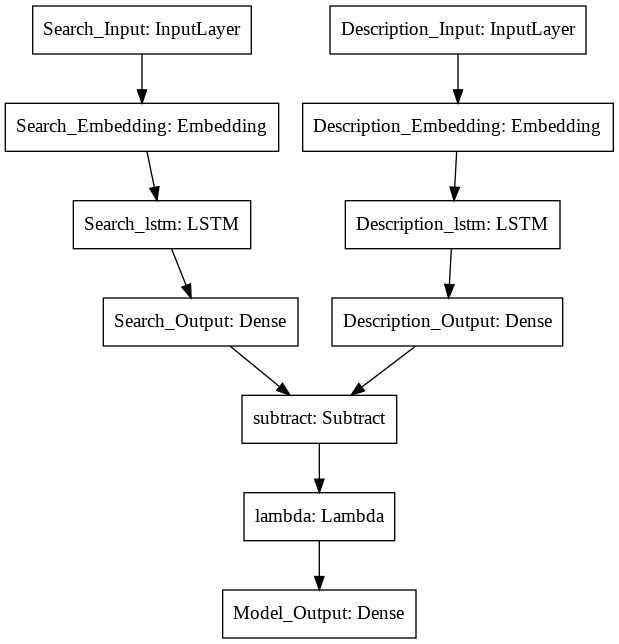

In [ ]:
plot_model(siamese_net_char)

In [ ]:
# create train and validation 
x_train_char, x_val_char, y_train_char, y_val_char = train_test_split(train_df_char[['search_term', 'product_description']], train_df_char[['relevance']], test_size=0.2, shuffle=True)

In [ ]:
# padding for search item and product_description
x_train_search_item_char = np.array(pad_sequences(x_train_char.search_term ,maxlen=1000, padding='post', dtype='int32'))
x_train_product_description_char = np.array(pad_sequences(x_train_char.product_description ,maxlen=1000, padding='post', dtype='int32')) # 1000 instead of max_len_description because it would take long time to run

x_val_search_item_char = np.array(pad_sequences(x_val_char.search_term ,maxlen=1000, padding='post', dtype='int32'))
x_val_product_description_char = np.array(pad_sequences(x_val_char.product_description ,maxlen=1000, padding='post', dtype='int32'))

x_test_search_item_char = np.array(pad_sequences(test_df_char.search_term ,maxlen=1000, padding='post', dtype='int32'))
x_test_product_description_char = np.array(pad_sequences(test_df_char.product_description ,maxlen=1000, padding='post', dtype='int32'))


print('train search_term shape is',x_train_search_item_char.shape,'\nproduct description shape is',x_train_product_description_char.shape, )
print('val search_term shape is',x_val_search_item_char.shape,'\nproduct description shape is',x_val_product_description_char.shape, )
print('test search_term shape is',x_test_search_item_char.shape,'\nproduct description shape is',x_test_product_description_char.shape, )




train search_term shape is (59253, 1000) 
product description shape is (59253, 1000)
val search_term shape is (14814, 1000) 
product description shape is (14814, 1000)
test search_term shape is (112067, 1000) 
product description shape is (112067, 1000)


In [ ]:
# padding for relevance
y_train_relevance = np.array(y_train_char.relevance)

y_val_relevance = np.array(y_val_char.relevance)

y_test_relevance = np.array(test_df_char.relevance)


print('y_train_relevance search_term shape is',y_train_relevance.shape)
print('y_val_relevance search_term shape is',y_val_relevance.shape)
print('y_test_relevance search_term shape is',y_test_relevance.shape )

y_train_relevance search_term shape is (59253,)
y_val_relevance search_term shape is (14814,)
y_test_relevance search_term shape is (112067,)


In [ ]:
y_test_relevance

array([2.33, 2.33, 2.67, ..., 2.67, 1.  , 2.33])

In [ ]:
y_test_relevance.shape

(112067,)

In [ ]:
start_char_lstm = time.time()
history_char = siamese_net_char.fit(x=[x_train_search_item_char, x_train_product_description_char], y=y_train_relevance, epochs=10, batch_size=256,
                          verbose=1, callbacks=[], validation_data=([x_val_search_item_char, x_val_product_description_char], y_val_relevance))
runtime_char_lstm = time.time() - start_char_lstm

Epoch 1/10
232/232 [==============================] - 67s 245ms/step - loss: 1.0477 - mse: 1.0477 - mae: 0.7335 - root_mean_squared_error: 0.9522 - val_loss: 0.2899 - val_mse: 0.2899 - val_mae: 0.4428 - val_root_mean_squared_error: 0.5384
Epoch 2/10
232/232 [==============================] - 57s 246ms/step - loss: 0.2844 - mse: 0.2844 - mae: 0.4371 - root_mean_squared_error: 0.5332 - val_loss: 0.2854 - val_mse: 0.2854 - val_mae: 0.4355 - val_root_mean_squared_error: 0.5343
Epoch 3/10
232/232 [==============================] - 58s 251ms/step - loss: 0.2872 - mse: 0.2872 - mae: 0.4389 - root_mean_squared_error: 0.5359 - val_loss: 0.2850 - val_mse: 0.2850 - val_mae: 0.4398 - val_root_mean_squared_error: 0.5338
Epoch 4/10
232/232 [==============================] - 58s 251ms/step - loss: 0.2845 - mse: 0.2845 - mae: 0.4368 - root_mean_squared_error: 0.5334 - val_loss: 0.2883 - val_mse: 0.2883 - val_mae: 0.4419 - val_root_mean_squared_error: 0.5369
Epoch 5/10
232/232 [========================

In [ ]:
eval_train = siamese_net_char.evaluate([x_train_search_item_char, x_train_product_description_char], y_train_relevance)

1852/1852 [==============================] - 57s 31ms/step - loss: 0.2853 - mse: 0.2853 - mae: 0.4356 - root_mean_squared_error: 0.5342


In [ ]:
eval_val = siamese_net_char.evaluate([x_val_search_item_char, x_val_product_description_char], y_val_relevance)

463/463 [==============================] - 14s 30ms/step - loss: 0.2849 - mse: 0.2849 - mae: 0.4364 - root_mean_squared_error: 0.5337


In [ ]:
eval_test = siamese_net_char.evaluate([x_test_search_item_char, x_test_product_description_char], y_test_relevance)

3503/3503 [==============================] - 107s 31ms/step - loss: 0.2872 - mse: 0.2872 - mae: 0.4372 - root_mean_squared_error: 0.5359


In [ ]:
preds = siamese_net_char.predict([x_test_search_item_char, x_test_product_description_char])

In [ ]:
append_results('Char LSTM', runtime_char_lstm, eval_train[-1], eval_val[-1],
                     eval_test[-1], eval_train[-2], eval_val[-2],
                     eval_test[-2])

In [ ]:
results

,Model,Runtime,Train_RMSE,Val_RMSE,Test_RMSE,Train_MAE,Val_MAE,Test_MAE
0,Char LSTM,588.598047,0.53418,0.533738,0.535869,0.435614,0.436391,0.437229


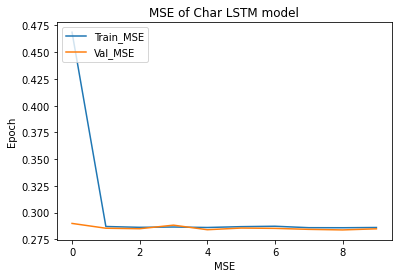

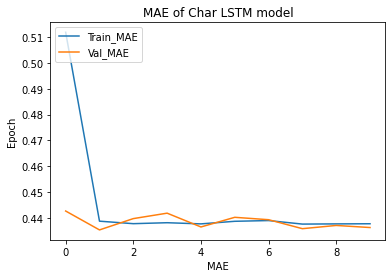

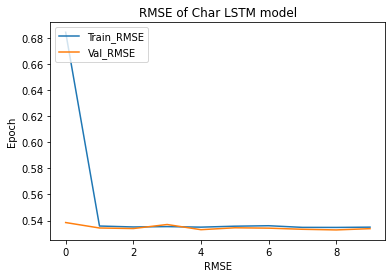

In [ ]:
def plot_model_indicator(history, train_indicator, val_indicator, title, x_label, y_label, legend):
  plt.plot(history[train_indicator])
  plt.plot(history[val_indicator])
  plt.title(title)
  plt.ylabel(x_label)
  plt.xlabel(y_label)
  plt.legend(legend, loc='upper left')
  plt.show()

plot_model_indicator(history_char.history, 'mse', 'val_mse', 'MSE of Char LSTM model', 'Epoch','MSE',['Train_MSE','Val_MSE'])
plot_model_indicator(history_char.history, 'mae', 'val_mae', 'MAE of Char LSTM model', 'Epoch','MAE',['Train_MAE','Val_MAE'])
plot_model_indicator(history_char.history, 'root_mean_squared_error', 'val_root_mean_squared_error', 'RMSE of Char LSTM model', 'Epoch','RMSE',['Train_RMSE','Val_RMSE'])



# c.	As in previous tasks we would like to create either a naïve or model-based benchmark – use count vectorizer on the character sequences you generated on (a) along with any modeling or statistical method to create such a benchmark score – remember, only by comparing your results with a strong benchmark will truly serve your will to asses how good your model is

In [ ]:
vectorizer = CountVectorizer(analyzer='char',vocabulary=tokens)

train_description_vec = vectorizer.transform(train_df.product_description).toarray()
train_search_vec = vectorizer.transform(train_df.search_term).toarray()

test_description_vec = vectorizer.transform(test_df.product_description).toarray()
test_search_vec = vectorizer.transform(test_df.search_term).toarray()

In [ ]:
train_description_vec[0]

array([128,   0,   2,   1,   0,   0,   0,   0,   2,   2,   0,   0,   4,
         7,   8,   2,   2,   6,   3,   2,   0,   0,   0,   0,   0,   2,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        42,   4,  29,  23,  78,  10,  17,  19,  46,   7,   4,  20,  15,
        63,  69,  10,   0,  58,  61,  56,  12,   8,   8,   6,   5,   5,
         0,   0,   0])

In [ ]:
train_search_vec[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 2,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [ ]:
y = train_df.relevance.values
y_test = test_df.relevance.values

In [ ]:
x = np.concatenate((train_description_vec,train_search_vec),axis = 1)
X_test =  np.concatenate((test_description_vec,test_search_vec),axis = 1)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state=42)

In [ ]:
x_train[0]

array([92,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  1,  2,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 60,  6, 32, 26, 57, 16,  8, 18, 46,  0,  4, 29,
       17, 36, 45, 13,  0, 35, 39, 39, 11,  2,  5,  1,  8,  0,  0,  0,  0,
        2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  2,  0,  1,  2,  4,  0,  2,  0,  0,  0,  0,  0,
        0,  2,  1,  0,  0,  2,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0])

In [ ]:
y_train

array([2.67, 2.67, 1.  , ..., 2.67, 1.67, 2.  ])

In [ ]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=25, max_depth=15)

In [ ]:
start_rf_benchmark = time.time()
rf.fit(x_train,y_train)
runtime_rf_benchmark = time.time() - start_rf_benchmark

In [ ]:
rf_train_predictions = rf.predict(x_train)
rf_val_predictions = rf.predict(x_val)
rf_test_predictions = rf.predict(X_test)

In [ ]:
rf_train_predictions

array([2.42505962, 2.4550093 , 1.33510512, ..., 2.37844363, 2.4852798 ,
       2.50923597])

In [ ]:
rf_train_rmse = sqrt(mean_squared_error(y_train, rf_train_predictions))
rf_val_rmse = sqrt(mean_squared_error(y_val, rf_val_predictions))
rf_test_rmse = sqrt(mean_squared_error(y_test, rf_test_predictions))

rf_train_mae = mean_absolute_error(y_train, rf_train_predictions)
rf_val_mae =  mean_absolute_error(y_val, rf_val_predictions)
rf_test_mae = mean_absolute_error(y_test, rf_test_predictions)

In [ ]:
print(f'Random Forest Train RMSE: {rf_train_rmse}')
print(f'Random Forest Val RMSE: {rf_val_rmse}')
print(f'Random Forest Test RMSE: {rf_test_rmse}')
print("----"*10)
print(f'Random Forest Train MAE: {rf_train_mae}')
print(f'Random Forest Val MAE: {rf_val_mae}')
print(f'Random Forest Test MAE: {rf_test_mae}')


Random Forest Train RMSE: 0.41880834553318697
Random Forest Val RMSE: 0.5050313518148385
Random Forest Test RMSE: 0.5252285529488847
----------------------------------------
Random Forest Train MAE: 0.34409260586396
Random Forest Val MAE: 0.4126602998915249
Random Forest Test MAE: 0.4292776870147871


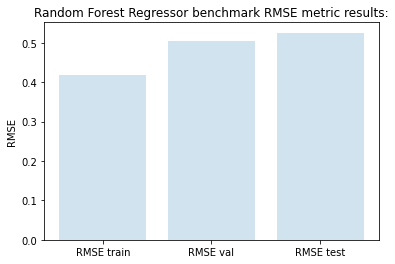

In [ ]:
plot_metrics_results('Random Forest Regressor benchmark','RMSE',rf_train_rmse,rf_val_rmse,rf_test_rmse)

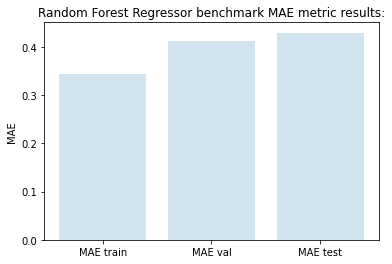

In [ ]:
plot_metrics_results('Random Forest Regressor benchmark','MAE',rf_train_mae,rf_val_mae,rf_test_mae)

In [ ]:
append_results('Random Forest Regressor benchmark', runtime_rf_benchmark, rf_train_rmse, rf_val_rmse,
                     rf_test_rmse, rf_train_mae, rf_val_mae,
                     rf_test_mae)

In [ ]:
results

,Model,Runtime,Train_RMSE,Val_RMSE,Test_RMSE,Train_MAE,Val_MAE,Test_MAE
0,Char LSTM,588.598047,0.534180,0.533738,0.535869,0.435614,0.436391,0.437229
1,Random Forest Regressor benchmark,20.070118,0.418808,0.505031,0.525229,0.344093,0.412660,0.429278


# d. Use the model you have got, either last layer or any other layer as a feature extractor for other ML model (please select at least two of: xgboost, lightgbm, catboost, random forest, knn, svm) 

In [ ]:
feature_extractor_char = Model(siamese_net_char.inputs, outputs=siamese_net_char.get_layer('subtract').output)

In [ ]:
x_train_features_char = feature_extractor_char.predict([x_train_search_item_char, x_train_product_description_char])
x_val_features_char = feature_extractor_char.predict([x_val_search_item_char, x_val_product_description_char])
x_test_features_char = feature_extractor_char.predict([x_test_search_item_char, x_test_product_description_char])

**Random Forest Regressor with feature extraction of LSTM character model Subtract layer**

In [ ]:
start_rf_fext = time.time()
rf_char = RandomForestRegressor(n_jobs=-1 ,n_estimators=25, max_depth=15)
rf_char.fit(x_train_features_char, y_train_char)
runtime_rf_fext = time.time() - start_rf_fext

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
rf_predictions_train_char = rf_char.predict(x_train_features_char)
rf_predictions_val_char = rf_char.predict(x_val_features_char)
rf_predictions_test_char = rf_char.predict(x_test_features_char)

In [ ]:
rf_train_rmse_char = sqrt(mean_squared_error(y_train_char, rf_predictions_train_char))
rf_val_rmse_char = sqrt(mean_squared_error(y_val_char, rf_predictions_val_char))
rf_test_rmse_char = sqrt(mean_squared_error(y_test, rf_predictions_test_char))

rf_train_mae_char = mean_absolute_error(y_train_char, rf_predictions_train_char)
rf_val_mae_char = mean_absolute_error(y_val_char, rf_predictions_val_char)
rf_test_mae_char = mean_absolute_error(y_test, rf_predictions_test_char)


In [ ]:
print(f'Random Forest Train RMSE: {rf_train_rmse_char}')
print(f'Random Forest Val RMSE: {rf_val_rmse_char}')
print(f'Random Forest Val RMSE: {rf_test_rmse_char}')
print("----"*10)
print(f'Random Forest Train MAE: {rf_train_mae_char}')
print(f'Random Forest Val MAE: {rf_val_mae_char}')
print(f'Random Forest Test MAE: {rf_test_mae_char}')


Random Forest Train RMSE: 0.511405805416568
Random Forest Val RMSE: 0.5335757978125683
Random Forest Val RMSE: 0.5371146825389874
----------------------------------------
Random Forest Train MAE: 0.4166520499519487
Random Forest Val MAE: 0.43729616299646934
Random Forest Test MAE: 0.43906884779515537


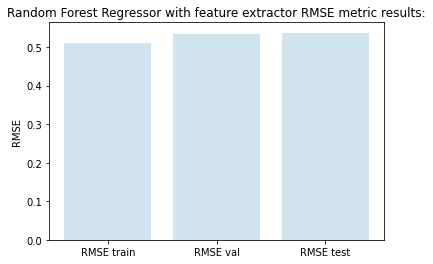

In [ ]:
plot_metrics_results('Random Forest Regressor with feature extractor','RMSE',rf_train_rmse_char,rf_val_rmse_char,rf_test_rmse_char)

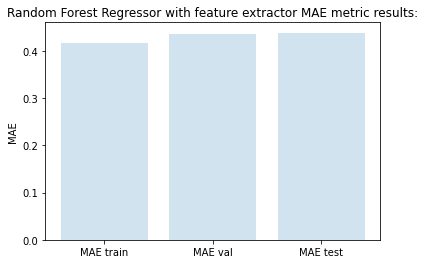

In [ ]:
plot_metrics_results('Random Forest Regressor with feature extractor','MAE',rf_train_mae_char,rf_val_mae_char,rf_test_mae_char)

In [ ]:
append_results('Random Forest Regressor with feature extractor', runtime_rf_fext, rf_train_rmse_char, rf_val_rmse_char,
                     rf_test_rmse_char, rf_train_mae_char, rf_val_mae_char,
                     rf_test_mae_char)

In [ ]:
results

,Model,Runtime,Train_RMSE,Val_RMSE,Test_RMSE,Train_MAE,Val_MAE,Test_MAE
0,Char LSTM,588.598047,0.534180,0.533738,0.535869,0.435614,0.436391,0.437229
1,Random Forest Regressor benchmark,20.070118,0.418808,0.505031,0.525229,0.344093,0.412660,0.429278
2,Random Forest Regressor with feature extractor,13.832969,0.511406,0.533576,0.537115,0.416652,0.437296,0.439069


**XGBoost with feature extraction of LSTM character model Subtract layer**

In [ ]:
xgb_char = XGBRegressor(n_jobs=-1)

In [ ]:
start_xgb_fext = time.time()
xgb_char.fit(x_train_features_char, y_train_char)
runtime_xgb_fext = time.time() - start_xgb_fext

[07:54:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgb_predictions_train_char = xgb_char.predict(x_train_features_char)
xgb_predictions_val_char = xgb_char.predict(x_val_features_char)
xgb_predictions_test_char = xgb_char.predict(x_test_features_char)

In [ ]:
xgb_train_rmse_char = sqrt(mean_squared_error(y_train_char, xgb_predictions_train_char))
xgb_val_rmse_char = sqrt(mean_squared_error(y_val_char, xgb_predictions_val_char))
xgb_test_rmse_char = sqrt(mean_squared_error(y_test, xgb_predictions_test_char))

xgb_train_mae_char = mean_absolute_error(y_train_char, xgb_predictions_train_char)
xgb_val_mae_char = mean_absolute_error(y_val_char, xgb_predictions_val_char)
xgb_test_mae_char = mean_absolute_error(y_test, xgb_predictions_test_char)


In [ ]:
print(f'XGBoost Train RMSE: {xgb_train_rmse_char}')
print(f'XGBoost Val RMSE: {xgb_val_rmse_char}')
print(f'XGBoost Test RMSE: {xgb_test_rmse_char}')
print("----"*10)
print(f'XGBoost Train MAE: {xgb_train_mae_char}')
print(f'XGBoost Val MAE: {xgb_val_mae_char}')
print(f'XGBoost Test MAE: {xgb_test_mae_char}')

XGBoost Train RMSE: 0.5322272890214622
XGBoost Val RMSE: 0.5323053043191498
XGBoost Test RMSE: 0.5349352005927916
----------------------------------------
XGBoost Train MAE: 0.4356048877640836
XGBoost Val MAE: 0.4367287282784715
XGBoost Test MAE: 0.43787083629924994


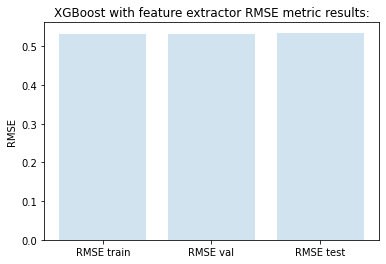

In [ ]:
plot_metrics_results('XGBoost with feature extractor','RMSE',xgb_train_rmse_char,xgb_val_rmse_char,xgb_test_rmse_char)

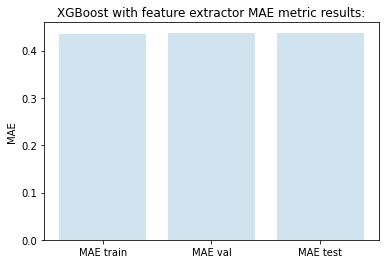

In [ ]:
plot_metrics_results('XGBoost with feature extractor','MAE',xgb_train_mae_char,xgb_val_mae_char,xgb_test_mae_char)

In [ ]:
append_results('XGBoost with feature extractor', runtime_xgb_fext, xgb_train_rmse_char, xgb_val_rmse_char,
                     xgb_test_rmse_char, xgb_train_mae_char, xgb_val_mae_char,
                     xgb_test_mae_char)

In [ ]:
results

,Model,Runtime,Train_RMSE,Val_RMSE,Test_RMSE,Train_MAE,Val_MAE,Test_MAE
0,Char LSTM,588.598047,0.534180,0.533738,0.535869,0.435614,0.436391,0.437229
1,Random Forest Regressor benchmark,20.070118,0.418808,0.505031,0.525229,0.344093,0.412660,0.429278
2,Random Forest Regressor with feature extractor,13.832969,0.511406,0.533576,0.537115,0.416652,0.437296,0.439069
3,XGBoost with feature extractor,7.912543,0.532227,0.532305,0.534935,0.435605,0.436729,0.437871
